In [1]:
import urllib2

import pandas as pd

In [ ]:
# Programmatically downloading the trip data for September 2015

link="https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"

response = urllib2.urlopen(link)
csvreader = response.read()

f=open("green_tripdata_2015-09.csv", 'wb')
f.write(csvreader)

https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-01.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-02.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-03.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-04.csv
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-05.csv


In [2]:
# Programmatically downloading from web and loading the trip data for September 2015


#link="https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
link="green_tripdata_2015-09.csv"
df=pd.read_csv(link)

#print list(df)
#df.isnull().sum(axis=0)

In [3]:
a,b=df.shape
print "Number of rows: ", a
print "Number of columns: ",b

Number of rows:  1494926
Number of columns:  21


In [5]:
import matplotlib.pyplot as plt

%matplotlib inline
#%matplotlib


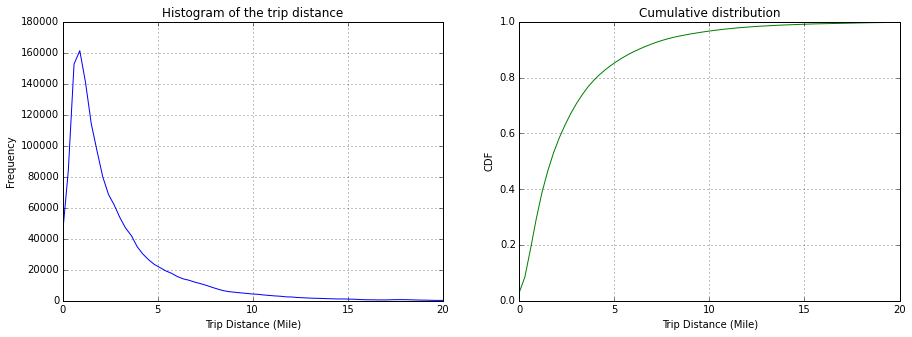

In [6]:
# Histogram of the number of the trip distance ("Trip Distance")
import numpy as np

plt.figure(figsize=(15,5))
# evaluate the histogram
values, base = np.histogram(df['Trip_distance'],bins=2000)
#evaluate the cumulative
cumulative = np.cumsum(values).astype(float)
cumulative /= cumulative[-1]
# plot the cumulative function

# plot the histogram
plt.subplot(121)
plt.plot(base[:-1], values, c='blue')
plt.xlabel('Trip Distance (Mile)')
plt.ylabel('Frequency')
plt.title('Histogram of the trip distance')
plt.xlim([0,20])
plt.grid()

#plot the cumulative histogram
plt.subplot(122)
plt.plot(base[:-1], cumulative, c='green')

plt.xlabel('Trip Distance (Mile)')
plt.ylabel('CDF')

plt.title('Cumulative distribution')
plt.xlim([0,20])
plt.grid()
plt.show()

The histogram of the trip distance shows that the majority of trips are around one mile, and then the number of trips with higher trip distances decay drastically. 

The histogram of the trip distance shows two different patterns:
    - Number of trips with distance less than 0.9-1 mile which increase rapidly until around one mile 
    - Number of trips with distance higher than 1-1.1 mile which decay in a light-tailed distribution

Emperical cumulative probability distribution shows that %2 of trips are zero-disctance trips, %25 of trips are less than one mile, %52 of trips are less than 2 miles, %78 of trips are less than 4 miles, and %95 of trips are less than 9 miles.

Due to the continuous positive-valued nature of the trip distance, the Rayleigh distribution ($f(x;\sigma )={\frac {x}{\sigma ^{2}}}e^{-x^{2}/(2\sigma ^{2})},~ x\geq 0$) could be a potential generative probability distribution model. 
However, simulation shows that the decay rate is less than $e^{-x^{2}}$.


Noticing here that the distances are measured in New York city which has a grid layout structure, it is reasonable to think about Manhattan distance rather than Euclidean distance. 
Therefore, the longtitute and latitute could be generated from independent Poisson variables, $X$ and $Y$ with parameters $\lambda_x$ and $\lambda_y$.

Then the trip distance is $R= \sqrt{L_x X^2+L_y Y^2}$, where $L_x$ and $L_y$ are the average horizental and vertical distance of the grids.

To test this hypothesis, I can find the maximum likelihood estimation of the latent parameters $L_x$ and $L_y$ and Poisson distributions, $\lambda_x$ and $\lambda_y$ using Expectation-Maximization method and check how well the Poisson distribution hypothesis could fit the underlying distribution for the distance random variable.

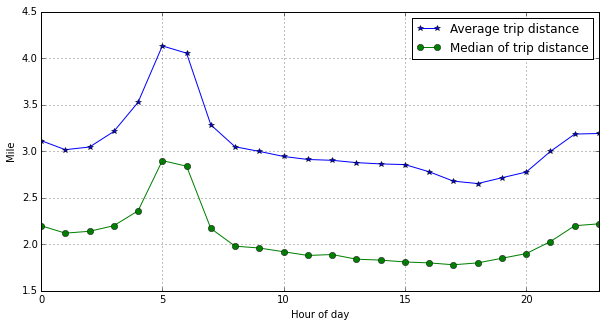

In [7]:
# Reporting the mean and median trip distance grouped by hour of day

import datetime

# Changing the format to datetime
df['lpep_pickup_datetime']=pd.to_datetime(df['lpep_pickup_datetime']) 

# grouping the data by the hour of day
df['hour']=df['lpep_pickup_datetime'].apply(lambda x: x.hour)

# Calculating the mean and median trip distance grouped by hour of day
a=df.groupby('hour')['Trip_distance'].mean()
b=df.groupby('hour')['Trip_distance'].median()

#Ploting the mean and median trip distance grouped by hour of day 

#%matplotlib inline
#%matplotlib 

plt.figure(figsize=(10,5))

plt.plot(range(len(a)),a,'-*',range(len(b)),b,'-o')
plt.xlabel('Hour of day')
plt.ylabel('Mile')
plt.grid()


plt.legend(['Average trip distance','Median of trip distance'])
plt.xlim([0,23])

plt.show()

## Trips originating or terminating at one of the NYC area airports

To study the behavior of trips originating or terminating at one of the NYC area airports, I have used two appraches:
    - Exatracting trips that originate or terminate at one of the NYC area airports from geo-location data for JFK, EWR and LGA airports
    - Extracting trips that originate or terminate at one of the NYC area airports from 'RateCodeID' data
    
### Airports from Geo-Location Data:

I retrieved the latitude and longtitude iformation for JFK, EWR and LGA airports using google map, and then, checked if the pick-up or drop-off locations are within a given distance of those airports as it is shown below.

<img src="NYC_airports.png" style='width: 900px' />

The geo-location information are showon at the following table

|Originate or destication| Count|% Correct RateCodeID|
|---|---|--|
|EWR_destination|666|% 63|
|EWR_origin|40|% 1|
|JFK_destination|12651|% 18|
|JFK_origin|283|% 7|
|LGA_destination|17919|% 0|
|LGA_origin|362|% 0|
|Town|1463005|-|

As it can be seen from the table, the majority of trips that happen in an airport area don't have the airport RateCodeID.
Therfore, the fare and accordingly, the tip are not calculated based on airport trips. 
Thus, the geo-location information doesn't identify the trips that originate or terminate at one of the NYC area airports

### Airports from RateCodeID Data

In this scenario, I use 'RateCodeID' data to identify if a trip is originated or terminated at JFK or EWR airports . 

|Airport|Count| Paid by credit Card| non-zero distance trip|Average distance| Average Fare|
|--|--|--|--| --|--|--|
|JFK|4435|1588|1563|10.24|49.0|
|EWR|1117|395|385|10.91|48.8|

#### Here are some interesting charcteristic of airport trips

- The data on the tip amount is available just for the credit card payment method. 
- Though the averag trip distance and average fare value for EWR and JFK are close to each other, but the trip distance and the fare value for EWR and JFK have totally different distributions (histograms).

The trip distance histogram shows that the majority of trips to or from JFK airport are populated around 16-20 miles. 
This observation makes sense since, using google map information, the distances from lower Manhattan, midtwon Manhattan and upper Manhattan to JFK are around 16-18 miles. 

However, trips to or from EWR are populated more uniformly around 0-30 miles, with higher density around 16 and 26 miles.
This observation also tallies data from google map information, where the distances from lower Manhattan, midtwon Manhattan and upper Manhattan to EWR airport are around 15, 17 and 25 miles. 

<img src="Trip_histogram_airport.png" style='width: 900px' />

On the other hand, the fare distributions show that trips to or from JFK airport have flat rate of \$52 and trips to EWR airport have a minimum charge of \$20.

It seems that the fixed rate of \$52 makes the trip fare from (to) JFK airport happens to (from) Manhattan reasonable but not other origin-destination pairs.

However, the variable rate to EWR airport makes the fare reasonable for both passengers located in manhattan and off-manhattan.

<img src="Fare_histogram_airport.png" style='width: 900px' />


In [165]:
# Airports from Geo-Location Data

from geopy.distance import vincenty

def loc_code(df):
    
    JFK=(40.6468217,-73.7846603)
    LGA=(40.7738209,-73.8695469)
    EWR=(40.6907392,-74.1772156)
    
    JFK_radius=1000
    LGA_radius=700
    EWR_radius=1000
    try:
        pickup=(df['Pickup_latitude'], df['Pickup_longitude'])
        dropoff=(df['Dropoff_latitude'], df['Dropoff_longitude'])

        
        if vincenty(JFK, pickup).meters < JFK_radius:
            return 'JFK_origin'

        elif vincenty(JFK, dropoff).meters < JFK_radius:
            return 'JFK_destination'


        elif vincenty(EWR, pickup).meters < EWR_radius:
            return 'EWR_origin'

        elif vincenty(EWR, dropoff).meters < EWR_radius:
            return 'EWR_destination'


        elif vincenty(LGA, pickup).meters < LGA_radius:
            return 'LGA_origin'

        elif vincenty(LGA, dropoff).meters < LGA_radius:
            return 'LGA_destination'

        else:
            return 'Town'
    
    except:
        
        return 'None'
    
df['loc_code']=df.apply(loc_code,axis=1)        

In [179]:
print 'Location code'
print df.groupby('loc_code')['VendorID'].count()

print "\nJFK_origin\n", df.groupby('loc_code').get_group('JFK_origin').groupby('RateCodeID')['VendorID'].count()
print '\nJFK_destination\n',df.groupby('loc_code').get_group('JFK_destination').groupby('RateCodeID')['VendorID'].count()
print '\nEWR_destination\n',df.groupby('loc_code').get_group('EWR_destination').groupby('RateCodeID')['VendorID'].count()
print '\nEWR_origin\n',df.groupby('loc_code').get_group('EWR_origin').groupby('RateCodeID')['VendorID'].count()


Location code
loc_code
EWR_destination        666
EWR_origin              40
JFK_destination      12651
JFK_origin             283
LGA_destination      17919
LGA_origin             362
Town               1463005
Name: VendorID, dtype: int64

JFK_origin
RateCodeID
1     93
2     19
3      1
4      1
5    169
Name: VendorID, dtype: int64

JFK_destination
RateCodeID
1    9632
2    2330
3       5
4       1
5     683
Name: VendorID, dtype: int64

EWR_destination
RateCodeID
1    155
2      3
3    419
4     22
5     67
Name: VendorID, dtype: int64

EWR_origin
RateCodeID
1    13
3     3
5    24
Name: VendorID, dtype: int64


In [9]:
# Airports from RateCodeID Data
# Trips that originate or terminate at one of the NYC area airports

grouped=df.groupby(['RateCodeID'])

JFK_group=grouped.get_group(2)
EWR_group=grouped.get_group(3)

JFK_group['Tip_amount']

a=grouped['Tip_amount'].mean()[1:3]


In [10]:
print 'JFK airport: ', JFK_group['Tip_amount'].count()
print 'JFK paid by credit: ', JFK_group['Tip_amount'][JFK_group['Tip_amount']>0].count()
print 'JFK paid by credit, non-zero trip distance: ',\
JFK_group['Tip_amount'][JFK_group['Tip_amount']>0][ JFK_group['Trip_distance']>0].count()
print 'JFK Average fair: ', JFK_group['Fare_amount'].mean()
print 'JFK Average fair: ', JFK_group['Fare_amount'].median()
print 'JFK airport: ', JFK_group['Trip_distance'].mean()



print '\nEWR airport: ', EWR_group['Tip_amount'].count()
print 'EWR paid by credit: ', EWR_group['Tip_amount'][EWR_group['Tip_amount']>0].count()
print 'EWR paid by credit, non-zero trip distance: ', \
EWR_group['Tip_amount'][EWR_group['Tip_amount']>0][EWR_group['Trip_distance']>0].count()
print 'EWR Average fair: ', EWR_group['Fare_amount'].mean()
print 'EWR Average fair: ', EWR_group['Fare_amount'].median()
print 'EWR Average fair: ', EWR_group['Fare_amount'][EWR_group['Fare_amount']>0].min()
print 'EWR airport: ', EWR_group['Trip_distance'].mean()


JFK airport:  4435
JFK paid by credit:  1588
JFK paid by credit, non-zero trip distance:  1563
JFK Average fair:  49.0218714769
JFK Average fair:  52.0
JFK airport:  10.2447846674

EWR airport:  1117
EWR paid by credit:  395
EWR paid by credit, non-zero trip distance:  385
EWR Average fair:  48.7985675918
EWR Average fair:  44.5
EWR Average fair:  20.0
EWR airport:  10.9078961504


KeyError: 0

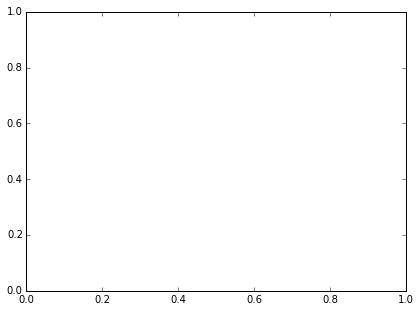

In [12]:
#%matplotlib 

plt.figure(figsize=[15,5])
plt.subplot(121)
plt.hist(JFK_group['Trip_distance'],bins=100)
plt.xlim([0,40])
plt.xlabel('Trip distance (mile)')
plt.ylabel('Frequency')
plt.title('JFK airport')
plt.grid()

plt.subplot(122)
plt.hist(EWR_group['Trip_distance'],bins=100)
plt.xlim([0,40])
plt.xlabel('Trip distance (mile)')
plt.ylabel('Frequency')
plt.title('EWR airport')
plt.grid()


plt.show()

KeyError: 0

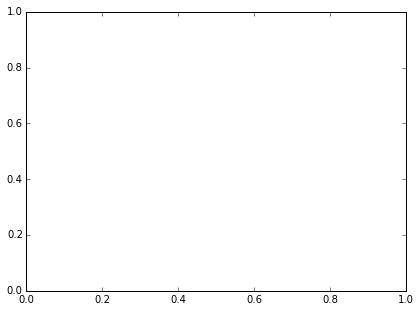

In [13]:
plt.figure(figsize=[15,5])

plt.subplot(121)
plt.hist(JFK_group['Fare_amount'], bins=100)
plt.xlim([0,150])
plt.xlabel("Fare amount")
plt.ylabel("Frequency")
plt.title("JFK")
plt.grid()

plt.subplot(122)
plt.hist(EWR_group['Fare_amount'], bins=50)
plt.xlim([0,150])
plt.xlabel("Fare amount")
plt.ylabel("Frequency")
plt.title("EWR")
plt.grid()


plt.show()

In [14]:
print 'JFK airport: ', JFK_group['Trip_distance'][JFK_group['Trip_distance']==0].count()
print 'EWR airport: ', EWR_group['Trip_distance'][EWR_group['Trip_distance']==0].count()

JFK airport:  942
EWR airport:  242


## Tip percentage

The tip information is just available for credit card transations whihc are %46.91 of all data records. 
The histogram for credit card trnsactions is plotted here:

<img src="Tip_percent_histogram.png" style='width: 900px' />

The histogram shows that the tip percentage is populated around %0, %16, %20 and %23.


In [15]:
df['Tip_percent']=df['Tip_amount'].div(df['Total_amount'])*100

In [16]:
print "Percent of credit card transactions:", \
("%.2f" % (df.groupby('Payment_type').get_group(1)['VendorID'].count()/float(df['VendorID'].count())*100))

Percent of credit card transactions: 46.91


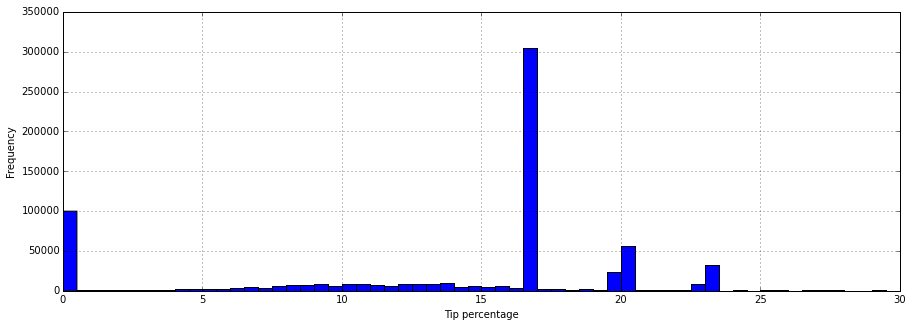

In [17]:
plt.figure(figsize=[15,5])

plt.hist(df.groupby('Payment_type').get_group(1)['Tip_percent'].dropna(),bins=200)
plt.xlabel('Tip percentage')
plt.ylabel('Frequency')
plt.xlim([0,30])
plt.grid()


plt.show()

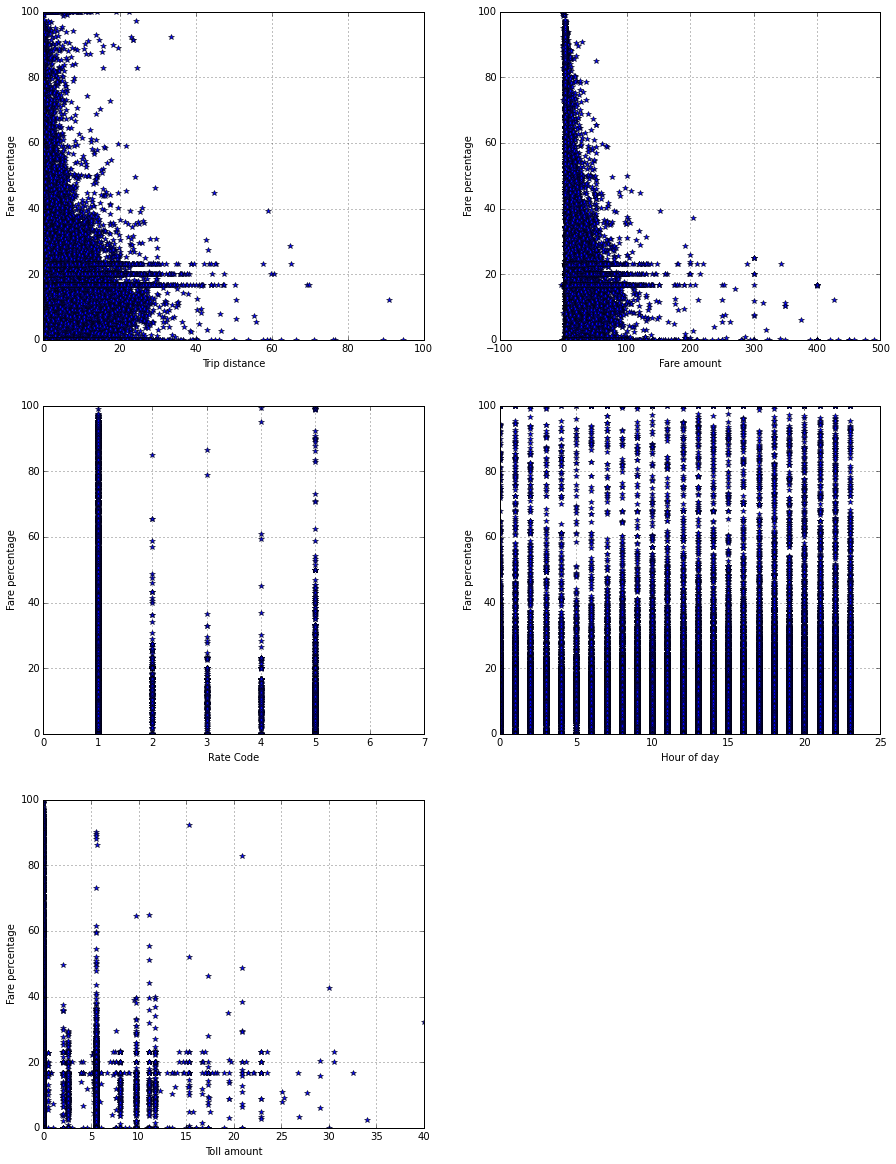

In [18]:
plt.figure(figsize=[15,20])

M=3
N=2
i=1

plt.subplot(M,N,i)

plt.plot(df.groupby('Payment_type').get_group(1)['Trip_distance'],df.groupby('Payment_type').get_group(1)['Tip_percent'],'*')
plt.xlabel("Trip distance")
plt.ylabel("Fare percentage")
plt.xlim([0,100])
plt.grid()

i+=1
plt.subplot(M,N,i)
plt.plot(df.groupby('Payment_type').get_group(1)['Fare_amount'],df.groupby('Payment_type').get_group(1)['Tip_percent'],'*')
plt.xlabel("Fare amount")
plt.ylabel("Fare percentage")
plt.grid()


i+=1
plt.subplot(M,N,i)
plt.plot(df.groupby('Payment_type').get_group(1)['RateCodeID'],df.groupby('Payment_type').get_group(1)['Tip_percent'],'*')
plt.xlabel("Rate Code")
plt.ylabel("Fare percentage")
plt.xlim([0,7])
plt.grid()

i+=1
plt.subplot(M,N,i)

plt.plot(df.groupby('Payment_type').get_group(1)['hour'],df.groupby('Payment_type').get_group(1)['Tip_percent'],'*')
plt.xlabel("Hour of day")
plt.ylabel("Fare percentage")
plt.grid()

i+=1
plt.subplot(M,N,i)

plt.plot(df.groupby('Payment_type').get_group(1)['Tolls_amount'],df.groupby('Payment_type').get_group(1)['Tip_percent'],'*')
plt.xlabel("Toll amount")
plt.ylabel("Fare percentage")
plt.xlim([0,40])
plt.grid()

plt.show()

In [19]:
plt.figure(figsize=[10,10])

plt.subplot(221)
plt.hist(JFK_group['Tip_amount'][JFK_group['Tip_amount']>0], bins=100)
plt.xlim([0,150])
plt.xlabel("Tip amount")
plt.ylabel("Frequency")
d=JFK_group['Tip_amount'][JFK_group['Tip_amount']>0].shape
plt.title("JFK, Non-zero data size: %d"% d)
plt.grid()

plt.subplot(222)
plt.hist(EWR_group['Tip_amount'][EWR_group['Tip_amount']>0], bins=50)
plt.xlim([0,150])
plt.xlabel("Tip amount")
plt.ylabel("Frequency")
d=EWR_group['Tip_amount'][EWR_group['Tip_amount']>0].shape
plt.title("EWR, Non-zero data size: %d"% d)
plt.grid()


plt.subplot(223)
plt.hist(JFK_group['Fare_amount'][JFK_group['Fare_amount']>0], bins=100)
plt.xlim([0,150])
plt.xlabel("Fare amount")
plt.ylabel("Frequency")
d=JFK_group['Fare_amount'][JFK_group['Fare_amount']>0].shape
plt.title("JFK, Non-zero data size: %d"% d)
plt.grid()

plt.subplot(224)
plt.hist(EWR_group['Fare_amount'][EWR_group['Fare_amount']>0], bins=50)
plt.xlim([0,150])
plt.xlabel("Fare amount")
plt.ylabel("Frequency")
d=EWR_group['Fare_amount'][EWR_group['Fare_amount']>0].shape
plt.title("EWR, Non-zero data size: %d"% d)
plt.grid()


plt.show()

In [19]:
print list(df)

['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude', 'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge', 'Total_amount', 'Payment_type', 'Trip_type ', 'hour', 'Tip_percent']


In [20]:
predictives=['VendorID',  'RateCodeID', 'hour',\
             'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude', 'Passenger_count', \
             'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tolls_amount', 'improvement_surcharge', \
              'Trip_type ']
target=['Tip_percent']

X=df.groupby('Payment_type').get_group(1)[predictives]
y=df.groupby('Payment_type').get_group(1)[target]

print X.shape
X.isnull().sum(axis=0)

(701287, 15)


VendorID                 0
RateCodeID               0
hour                     0
Pickup_longitude         0
Pickup_latitude          0
Dropoff_longitude        0
Dropoff_latitude         0
Passenger_count          0
Trip_distance            0
Fare_amount              0
Extra                    0
MTA_tax                  0
Tolls_amount             0
improvement_surcharge    0
Trip_type                3
dtype: int64

In [21]:
X['Trip_type '].fillna(3, inplace=True)

X.isnull().sum(axis=0)

VendorID                 0
RateCodeID               0
hour                     0
Pickup_longitude         0
Pickup_latitude          0
Dropoff_longitude        0
Dropoff_latitude         0
Passenger_count          0
Trip_distance            0
Fare_amount              0
Extra                    0
MTA_tax                  0
Tolls_amount             0
improvement_surcharge    0
Trip_type                0
dtype: int64

In [22]:
y['Tip_percent'].fillna(0, inplace=True)
y.isnull().sum(axis=0)

Tip_percent    0
dtype: int64

In [34]:
from sklearn.cross_validation import train_test_split

X1, X_test, y1, y_test = train_test_split(X, y,test_size=.2,random_state=4)

/home/amir/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [38]:
from sigopt import Connection




# SigOpt optimization loop

conn = Connection(client_token="TCJITYTTBAVUNHZAFDQLWZAPFTCNAXNZTTTLLBLOWEASLINN")

experiment = conn.experiments().create(
    name='SGD Optimization (Python)',
    parameters=[
        dict(name='max_depth', type='int', bounds=dict(min=10, max=100)),
        dict(name='n_estimators', type='int', bounds=dict(min=1, max=15)),
        dict(name='criterion', type='categorical', categorical_values=[{"name":'mse'}, {"name":'mae'}]),
    ],
)
print("Created experiment: https://sigopt.com/experiment/" + experiment.id)

# Evaluate your model with the suggested parameter assignments
def evaluate_model(assignments):
    regr_rf = RandomForestRegressor(max_depth=assignments['max_depth'], random_state=2,\
                                    n_estimators=assignments['n_estimators'],\
                                   criterion =assignments['criterion'])
    score=[]
    
    cv=3
    for _ in range(cv):
        X_train, X_cv, y_train, y_cv = train_test_split(X1, y1,test_size=.5)

        regr_rf.fit(X_train, y_train)
    
        score.append(regr_rf.score(X_cv, y_cv))
        print score
    
    return np.mean(score)

best_value=0


# Run the Optimization Loop between 10x - 20x the number of parameters
for _ in range(30):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    
    value = evaluate_model(suggestion.assignments)
    
    print 'max_depth= ',suggestion.assignments['max_depth'], \
    ', n_estimators= ',suggestion.assignments['n_estimators'],\
    ', criterion= ' ,suggestion.assignments['criterion'],', Value= ', value
    
    if value > best_value:
        best_value=value
        best_suggestion=suggestion
        
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value,
    )

print '\nBEST VALUE:'    
print 'max_depth= ',best_suggestion.assignments['max_depth'],\
', n_estimators= ',best_suggestion.assignments['n_estimators'],\
', criterion= ', suggestion.assignments['criterion'], ', Value= ', best_value

AttributeError: 'Extensions' object has no attribute 'get_extension_for_class'

In [164]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


X_train, X_cv, y_train, y_cv = train_test_split(X1, y1,test_size=.2,random_state=4)

max_depth = best_suggestion.assignments['max_depth']
n_estimators= best_suggestion.assignments['n_estimators']

regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2,n_estimators=n_estimators)
regr_rf.fit(X_train, y_train)

C:\Users\Amir\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=11, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

In [165]:
regr_rf.score(X_train, y_train)

0.24786243821231602

In [166]:
regr_rf.score(X_cv, y_cv)

0.16733212876984727

In [167]:
regr_rf.score(X_test, y_test)

0.15751045441448974

In [92]:
np.mean([0.15191488370827644, 0.15191488370827644])

0.15191488370827644

In [163]:
import numpy as np

a=regr_rf.feature_importances_

index=np.arange(len(a))
label=list(X)
plt.barh(index,a,color='y')
plt.yticks(index+0.5, label, rotation='horizontal')
plt.grid()
plt.show()


In [157]:
index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [72]:
X_JFK_train['Fare_amount']

447514     52.0
1166051    52.0
93485      52.0
586080     52.0
933572     52.0
1028327    52.0
1013604    52.0
494555     52.0
1137982    52.0
1211779    52.0
1472370    52.0
1131790    52.0
222447     52.0
1114099    52.0
451435     52.0
940292     52.0
263629     52.0
1165518    52.0
211245     52.0
556770     52.0
183187     52.0
773605     52.0
1459628    52.0
627367     52.0
65759      52.0
1270597    52.0
1112308    52.0
1265674    52.0
80040      52.0
1137192    52.0
           ... 
57991      52.0
1329670    52.0
1340670    52.0
347374     52.0
114512     52.0
449945     52.0
145299     52.0
914691     52.0
1212310    52.0
1382159    52.0
1042615    52.0
1162376    52.0
944497     52.0
847874     52.0
1466944    52.0
1169851    52.0
849505     52.0
734217     52.0
1412884    52.0
91832      52.0
985321     52.0
322011     52.0
728442     52.0
387908     52.0
1408166    52.0
308612     52.0
640779     52.0
361811     52.0
140415     52.0
1035539    52.0
Name: Fare_amount, dtype

In [73]:
y_JFK_pred=regr_rf.predict(X_JFK_train)

In [74]:
print y_JFK_pred[1:100]
y_JFK_train[1:100]

[ 11.287       11.36387987   5.77597802   7.34436508  12.429        6.809
  12.664       34.2         10.4382       9.36097802   8.67736508
   5.13236508  14.851        8.60897802   9.42969231   2.508125    10.69
  11.17657576   7.725        6.55        11.169       11.76772603  10.794
  12.43490909   9.562        5.89072603  11.75877802  11.37681508  12.831
  12.021       10.519       14.706        3.2         10.66597802
  11.17388711   6.80772603  12.749       13.623        2.514        9.101
  13.831       12.65757895   9.918       11.39        79.          10.95131893
   8.514        8.70772603  11.503        9.14436508   9.89338095
   7.79538095  16.917       10.113       10.461       12.252       10.334
   4.487       12.75490909  13.707       11.559       11.11324561   3.8
   8.468        8.257        3.          11.501        9.85435897   6.284
   6.76336508  10.706        9.27697802   9.71897802  11.83597802   1.72
   9.757       14.556       11.88325      8.09456508  14.846 

,Tip_amount
1166051,11.65
93485,11.67
586080,4.00
933572,5.00
1028327,14.58
1013604,3.50
494555,14.58
1137982,40.00
1211779,11.67
1472370,11.65


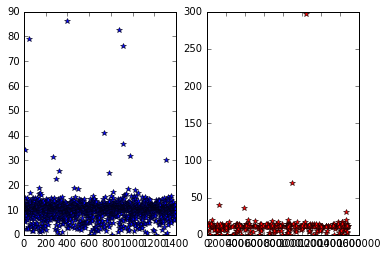

In [110]:
plt.figure()
plt.subplot(121)
plt.plot(y_JFK_pred, '*')
plt.subplot(122)
plt.plot(y_JFK_test,'r*')
plt.show()